# 4. Correlation Analysis

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from scipy import signal

plt.rcParams['font.size'] = 12
plt.rcParams['figure.dpi'] = 140

In [2]:
datadir = '../datasets/02/'
df = pd.read_csv(datadir + 'spikes.csv')

display(df.head())

,neuron,spiketime
0,1,20.95
1,1,93.55
2,1,107.40
3,1,116.45
4,1,218.45


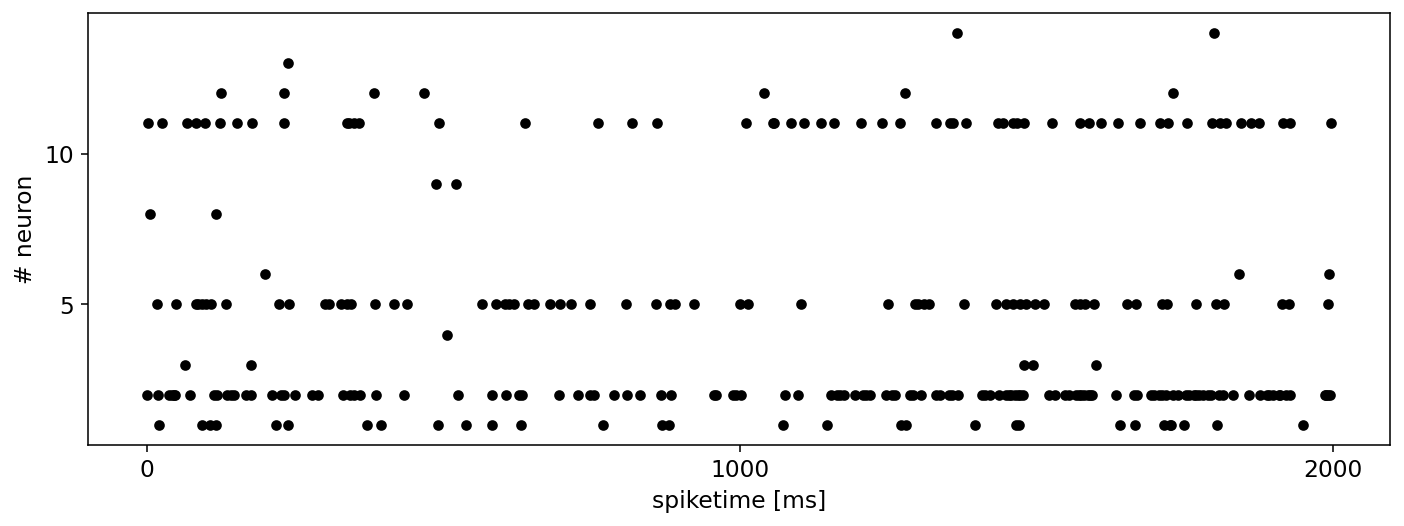

In [28]:
start, end = 0.0, 2000.0

fig, ax = plt.subplots(figsize=(12, 4))
df.query('@start <= spiketime <= @end').plot.scatter(x='spiketime', y='neuron', c='k', ax=ax)
ax.set_xlabel('spiketime [ms]')
ax.set_ylabel('# neuron')

plt.locator_params(axis='x', nbins=4)
plt.locator_params(axis='y', nbins=4)
plt.show()

## 4.1. Cross-Correlation

$W_{ij}$: neuron $j$からneuron $i$へのシナプス強度とする． 

In [4]:
def spiketime_relative(spike_times_i, spike_times_j, window_size=50.0):
    t_sp = []
    i_min, i_max = 0, 0

    for t_j in spike_times_j:
        # reuse search index for next iteration to decrease the amount of elements to scan
        i_min = _upper_bound_idx(lst=spike_times_i, upper=t_j - window_size, start_idx=i_min)
        i_max = _upper_bound_idx(lst=spike_times_i, upper=t_j + window_size, start_idx=i_max)
        t_sp.extend([(spike_times_i[i] - t_j) for i in range(i_min, i_max)])
        
    return t_sp

def _upper_bound_idx(lst, upper, start_idx=0):
    idx = start_idx
    while idx < len(lst) and lst[idx] <= upper:
        idx += 1
    return idx

In [35]:
def cross_correlogram(df, neuron_i, neuron_j, window=50., nbins=100):
    spike_times_i = df.query(f'neuron=={neuron_i}').spiketime.values
    spike_times_j = df.query(f'neuron=={neuron_j}').spiketime.values
    t_sp = spiketime_relative(spike_times_i, spike_times_j)
    hist, edges = np.histogram(t_sp, bins=np.linspace(-window, window, nbins))
    return hist, edges

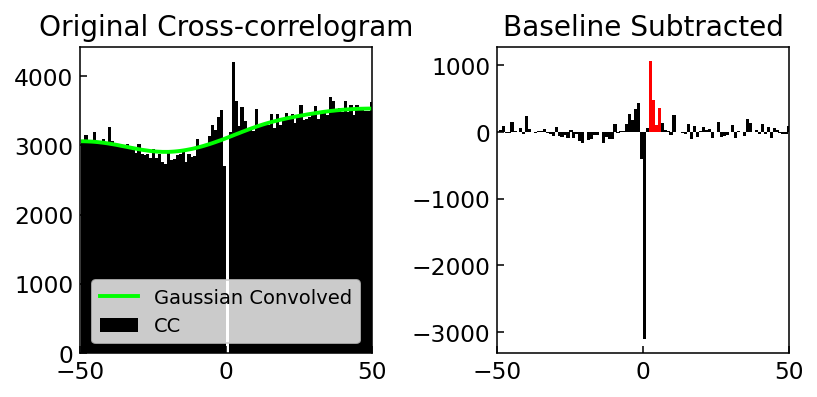

In [42]:
hist, edges = cross_correlogram(df=df, neuron_i=1, neuron_j=2)
hist_g = gaussian_filter(hist, sigma=[10])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))

ax1.set_title('Original Cross-correlogram')
ax1.bar(edges[1:], hist, color='k', width=1.1, label='CC')
ax1.plot(edges[1:], hist_g, color='lime', linewidth=2.0, label='Gaussian Convolved')
ax1.legend(fontsize=10, loc='lower center')
ax1.set_xlim(-50, 50)
ax1.set_xticks([-50, 0, 50])
ax1.tick_params(direction='in')

hist_sub = hist - hist_g
ax2.set_title('Baseline Subtracted')
ax2.bar(edges[1:], hist_sub, color='k', width=1.1)
ax2.bar(edges[1:][51:55], hist_sub[51:55], color='r', width=1.1)
ax2.set_xlim(-50, 50)
ax2.set_xticks([-50, 0, 50])
ax2.tick_params(direction='in')

plt.tight_layout()
plt.show()

## 4.2. Effective Connectivity Map

In [86]:
import itertools
import seaborn as sns
import networkx as nx

In [48]:
def estimate_connectivity(df, neuron_i, neuron_j, start=1, end=5, window=50., nbins=100):
    spike_times_i = df.query(f'neuron=={neuron_i}').spiketime.values
    spike_times_j = df.query(f'neuron=={neuron_j}').spiketime.values
    t_sp = spiketime_relative(spike_times_i, spike_times_j)
    
    hist, edges = np.histogram(t_sp, bins=np.linspace(-window, window, nbins))
    hist_g = gaussian_filter(hist, sigma=[10])
    hist_sub = hist - hist_g

    w_ij = np.sum(hist_sub[nbins // 2 + start : nbins // 2 + end]) / len(spike_times_j)
    w_ji = np.sum(hist_sub[nbins // 2 - end : nbins // 2 - start]) / len(spike_times_i)
    return w_ij, w_ji

In [80]:
df_ = df.copy()
df_.neuron = df_.neuron - 1  # change neuron idx so it starts from 0 (that way it's easier for weight matrix)

neurons = set(df_.neuron)
n_neurons = len(neurons)
w = np.zeros((n_neurons, n_neurons))

for (i, j) in itertools.combinations(neurons, 2):
    if i == j:
        continue
    else:
        w_ij, w_ji = estimate_connectivity(df=df_, neuron_i=i, neuron_j=j)
        w[i, j] = w_ij
        w[j, i] = w_ji

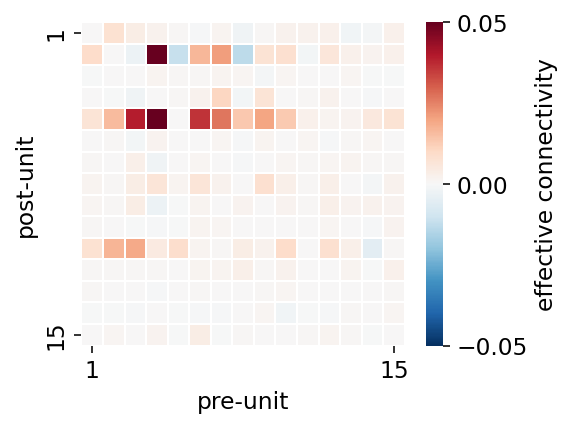

In [131]:
fig, ax = plt.subplots(figsize=(4, 3))

sns.heatmap(w, vmax=0.05, vmin=-0.05, center=0, ax=ax, cmap=plt.get_cmap('RdBu_r'), 
            linewidths=1.0, cbar_kws=dict(ticks=[0.05, 0, -0.05], label='effective connectivity'))

ax.set_xticks([0.5, 14.5])
ax.set_yticks([0.5, 14.5])
ax.set_xticklabels([1, 15])
ax.set_yticklabels([1, 15])

ax.set_xlabel('pre-unit')
ax.set_ylabel('post-unit')
ax.set_aspect('equal')
plt.show()

In [123]:
G = nx.DiGraph()

for neuron in neurons:
    G.add_node(neuron + 1)

for i in range(w.shape[0]):
    for j in range(w.shape[1]):
        w_ij = w[i, j]
        if w_ij > 0.01:
            G.add_edge(i + 1, j + 1, weight=w_ij, color='magenta')  # exc
        elif w_ij < -0.01:
            G.add_edge(i + 1, j + 1, weight=w_ij, color='cyan')  # inh

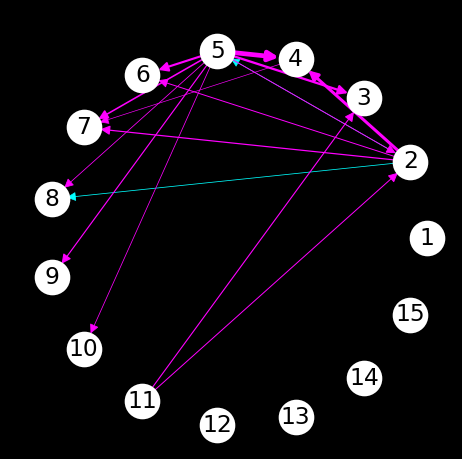

In [124]:
edges = G.edges()
edge_color = [G[u][v]['color'] for u, v in edges]
edge_width = [G[u][v]['weight'] * 30 for u, v in edges]

fig, ax = plt.subplots(figsize=(4, 4))
nx.draw(G, pos=nx.circular_layout(G), with_labels=True, node_color='w', font_color='k', 
        edge_color=edge_color, width=edge_width, arrows=True, arrowsize=10)

fig.set_facecolor('k')
plt.show()